<a href="https://colab.research.google.com/github/MishkaDewlok/PDAN8412_POE_PART1/blob/main/PDAN8412_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mishka Dewlok

ST10219921

PDAN8412 POE - PART 1

Dataset sourced from Kaggle at: https://www.kaggle.com/datasets/marufchowdhury/quote-dataset

This sets up the environment for the project in Google Colab. It ensures that all the required libraries are installed, upgrades pip, and then imports the necessary Python modules. Finally, it prints out the versions of Spark and TensorFlow so we can confirm that the correct setup is being used.

In [ ]:
# install required packages
!pip -q install --upgrade pip
!pip -q install kaggle pyspark==3.5.1 scikit-learn matplotlib

# import the common Python libraries EDA
import os, zipfile, sys, json, random, math, gc, pathlib, re
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

#print versions to confirm
print("Versions:")
import pyspark, sklearn, tensorflow as tf
print("Spark:", pyspark.__version__)
print("TF:", tf.__version__)


Versions:
Spark: 3.5.1
TF: 2.19.0


This sets up Kaggle in Colab and downloads the Quote Dataset being used for this project. After securely installing Kaggle, the dataset is fetched, unzipped and the main CSV file is automatically detected and loaded into a Pandas DataFrame. At this stage, quick dataset checks are performed such as available columns row counts and the number of unique authors.

These initial checks form the first step of **Exploratory Data Analysis (EDA)**. They allow for the understanding of the structure of the dataset and confirm it is suitable for this project. Later, further EDA steps (such as removing duplicates, filtering very short quotes,etc) build on this foundation. For now, these steps ensures we start with clean, accessible data first.

In [ ]:
# handles the Kaggle json file
from google.colab import files
print("Choose your kaggle.json")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded. Please upload kaggle.json")

uploaded_name = next(iter(uploaded))  # whatever the uploaded file is called
home_kaggle = Path.home() / ".kaggle"
home_kaggle.mkdir(parents=True, exist_ok=True)
cred_path = home_kaggle / "kaggle.json"
with open(cred_path, "wb") as f:
    f.write(uploaded[uploaded_name])
os.chmod(cred_path, 0o600)
!kaggle --version

# Download the quotes dataset
DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

!kaggle datasets download -d marufchowdhury/quote-dataset -p {DATA_DIR} -q

zip_path = DATA_DIR / "quote-dataset.zip"
alt_dir = DATA_DIR / "quote_dataset_alt"
alt_dir.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(alt_dir)

print("Extracted files:", [p.name for p in alt_dir.glob("*")])

# Pick the CSV automatically, then run some quick stats
csvs = sorted(alt_dir.glob("*.csv"))
if not csvs:
    raise FileNotFoundError(f"No CSVs found in {alt_dir}.")
cand = csvs[0]
print("Using CSV:", cand.name)

# Read
try:
    df_pd = pd.read_csv(cand, encoding="utf-8", engine="python", on_bad_lines="skip")
except Exception:
    df_pd = pd.read_csv(cand, encoding="latin-1", engine="python", on_bad_lines="skip")

print("Shape:", df_pd.shape)
print("Columns:", list(df_pd.columns))
display(df_pd.head(3))

# Quick size checks
author_col = "Author" if "Author" in df_pd.columns else ("author" if "author" in df_pd.columns else None)
print("Row count:", len(df_pd))
print("Unique authors:", df_pd[author_col].nunique() if author_col else "author column not found")


Choose your kaggle.json


Saving kaggle.json to kaggle (1).json
Kaggle API 1.7.4.5
Dataset URL: https://www.kaggle.com/datasets/marufchowdhury/quote-dataset
License(s): MIT
Extracted files: ['Quote_data.csv']
Using CSV: Quote_data.csv
Shape: (29355, 4)
Columns: ['Quote', 'Author', 'Tags', 'revised_tags']


,Quote,Author,Tags,revised_tags
0,“Be yourself; everyone else is already taken.”,Oscar Wilde,"attributed-no-source, be-yourself, gilbert-per...","['attributed-no-source', 'be-yourself', 'hones..."
1,“You've gotta dance like there's nobody watchi...,William W. Purkey,"dance, heaven, hurt, inspirational, life, love...","['dance', 'heaven', 'hurt', 'inspirational', '..."
2,“Be the change that you wish to see in the wor...,Mahatma Gandhi,"action, change, inspirational, misattributed-t...","['action', 'change', 'inspirational', 'philoso..."


Row count: 29355
Unique authors: 10982


This begins the **Spark EDA** and cleaning. It loads the CSV into a Spark DataFrame, inspects the schema and sample rows, then standardises column names to text and author. It performs key EDA cleaning steps:
1. trims whitespace
2. collapses multiple spaces
3. drops nulls
4. removes very short quotes (length < 15 characters)
4. and deduplicates on (text, author).

Finally, it shows the cleaned row count and number of distinct authors. These actions implement the early EDA objectives: verify structure, normalise fields, remove noise/duplicates, and prepare a reliable corpus for feature selection and modelling.

Reference:
Selvaraj, N. (2022). Pyspark Tutorial: Getting Started with Pyspark. [online] Datacamp.com. Available at: https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark. [Accessed: 27 September 2025]


In [ ]:
# use Spark for analysis
from pyspark.sql import SparkSession, functions as F

# Start a Spark session for EDA/cleaning
spark = SparkSession.builder.appName("AuthorID_LSTM_OptionB").getOrCreate()

# Load CSV into Spark DataFrame with header and schema
sdf = spark.read.csv(str(cand), header=True, inferSchema=True)
print("Raw row count:", sdf.count())
sdf.printSchema()
sdf.show(5, truncate=120)

cols_lower = [c.lower() for c in sdf.columns]
def rename_if(df, options, new_name):
    for n in options:
        if n in cols_lower:
            old = df.columns[cols_lower.index(n)]
            return df.withColumnRenamed(old, new_name)
    return df

sdf = rename_if(sdf, ["quote","quotes","text"], "text")
sdf = rename_if(sdf, ["author","writer"], "author")

#both required columns must exist for modelling
if "text" not in [c.lower() for c in sdf.columns]:
    raise ValueError(f"Expected a text column in {sdf.columns}")
if "author" not in [c.lower() for c in sdf.columns]:
    raise ValueError(f"Expected an author column in {sdf.columns}")

# EDA cleaning steps
sdf = (
    sdf
    .withColumn("text", F.trim(F.regexp_replace(F.col("text"), r"\s+", " ")))
    .withColumn("author", F.trim(F.regexp_replace(F.col("author"), r"\s+", " ")))
    .filter(F.col("text").isNotNull() & F.col("author").isNotNull())
    .filter(F.length("text") >= 15)
    .dropDuplicates(["text","author"])
)

print("After cleaning:", sdf.count())
print("Distinct authors:", sdf.select("author").distinct().count())


Raw row count: 49232
root
 |-- Quote: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- revised_tags: string (nullable = true)

+-------------------------------------------------+------------------+------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------+
|                                            Quote|            Author|                                                                                                                    Tags|                                                       revised_tags|
+-------------------------------------------------+------------------+------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------+
|   “Be yourself; everyone else is alr

This continues the **Exploratory Data Analysis (EDA)** by examining text length patterns and author distributions.

First, it calculates descriptive statistics for quote lengths (average, median, 90th percentile, maximum) to help determine a reasonable sequence length for model training.

Next, it groups quotes into length buckets to visualise how short, medium and long quotes are distributed across the dataset.

Finally, it lists the top 20 authors by quote count, which shows the imbalance problem where some authors are heavily represented compared to others. These insights help with later design choices such as maximum sequence length, filtering thresholds and class balancing strategies.

In [ ]:
# Quote length stats
sdf = sdf.withColumn("length", F.length("text"))

# average, median, 90th percentile and maximum length
sdf.select(
    F.mean("length").alias("avg_len"),
    F.expr("percentile(length, 0.5)").alias("median_len"),
    F.expr("percentile(length, 0.9)").alias("p90_len"),
    F.max("length").alias("max_len")
).show()

# Length buckets
sdf.groupBy(
    F.when(F.col("length")<50, "<50")
     .when(F.col("length")<100, "50-99")
     .when(F.col("length")<200, "100-199")
     .otherwise("200+")
     .alias("len_bucket")
).count().orderBy("len_bucket").show()

# Top authors
sdf.groupBy("author").count().orderBy(F.desc("count")).show(20, truncate=False)


+-----------------+----------+-------+-------+
|          avg_len|median_len|p90_len|max_len|
+-----------------+----------+-------+-------+
|153.8601268591426|      96.0|  343.0|   2612|
+-----------------+----------+-------+-------+

+----------+-----+
|len_bucket|count|
+----------+-----+
|   100-199| 7045|
|      200+| 6155|
|     50-99| 7927|
|       <50| 6305|
+----------+-----+

+----------------------------------------------------------------------------------+-----+
|author                                                                            |count|
+----------------------------------------------------------------------------------+-----+
|Roy T. Bennett, The Light in the Heart                                            |153  |
|Gordon Roddick                                                                    |151  |
|Albert Einstein                                                                   |93   |
|Criss Jami, Killosophy                                          

This builds a **Spark** baseline model to benchmark performance before  learning. It filters to authors with at least 100 quotes to reduce extreme class imbalance, constructs a classic TF-IDF text pipeline, encodes author names to numeric labels, trains a Logistic Regression classifier, and reports accuracy and F1. These results serve as a baseline for the later LSTM model, helping to judge whether the model delivers real value beyond a strong linear baseline.

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#eep only authors with a reasonable amount of data
MIN_PER_AUTHOR = 100
by_author = sdf.groupBy("author").count().withColumnRenamed("count","n_by_author")
sdf_small = (
    sdf.join(by_author, on="author")
       .filter(F.col("n_by_author") >= MIN_PER_AUTHOR)
       .select("text","author")
)

tok = Tokenizer(inputCol="text", outputCol="words")
rem = StopWordsRemover(inputCol="words", outputCol="filtered")
tf  = HashingTF(inputCol="filtered", outputCol="tf", numFeatures=(1<<14))  # 16,384 dims
idf = IDF(inputCol="tf", outputCol="features", minDocFreq=3)
lab = StringIndexer(inputCol="author", outputCol="label", handleInvalid="skip")

#fit the Spark pipeline
pipe = Pipeline(stages=[tok, rem, tf, idf, lab])
fm = pipe.fit(sdf_small)
sdf_f = fm.transform(sdf_small).select("text","author","features","label")

#Train/test split
train_sp, test_sp = sdf_f.randomSplit([0.8, 0.2], seed=42)

#Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label",
                        maxIter=80, regParam=0.01, elasticNetParam=0.0)
lr_model = lr.fit(train_sp)
pred_lr = lr_model.transform(test_sp)

#accuracy and macro F1
eva_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eva_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
print("Spark TF-IDF (16k) + LR accuracy:", round(eva_acc.evaluate(pred_lr), 4))
print("Spark TF-IDF (16k) + LR F1:",      round(eva_f1.evaluate(pred_lr), 4))


Spark TF-IDF (16k) + LR accuracy: 0.766
Spark TF-IDF (16k) + LR F1: 0.7692


This now begins the **Feature Selection** steps. The cleaned dataset is reused and filtered to authors with at least 100 quotes. Calculate length statistics of the text to guide the maximum sequence length (MAXLEN) that the model will process. The 90th percentile value is chosen to balance coverage (capturing most quotes) while avoiding excessive padding or memory use, capped at 160 tokens. Also define a vocabulary size (VOCAB_SIZE) of 30000, based on EDA and TF-IDF experiments, to capture frequent words. These steps ensure that the model works with a manageable but representative feature space, making training more efficient and fair.

In [ ]:

from pyspark.sql import functions as F

try:
    sdf_small
except NameError:
    MIN_PER_AUTHOR = 100  # minimum quotes per author
    by_author = sdf.groupBy("author").count().withColumnRenamed("count","n_by_author")
    sdf_small = (
        sdf.join(by_author, on="author")
           .filter(F.col("n_by_author") >= MIN_PER_AUTHOR)
           .select("text","author")
    )

# Length stats guide MAXLEN
sdf_len = sdf_small.withColumn("length", F.length("text"))
len_stats = sdf_len.select(
    F.expr("percentile(length, 0.5)").alias("p50"),
    F.expr("percentile(length, 0.9)").alias("p90"),
    F.expr("percentile(length, 0.95)").alias("p95"),
    F.max("length").alias("max_len")
).first()
print("Length stats:", dict(len_stats.asDict()))

# Decide MAXLEN
MAXLEN = int(min(max(80, len_stats['p90']), 160))
VOCAB_SIZE = 30000  # informed prior
print("Planning and MAXLEN:", MAXLEN, "| VOCAB_SIZE:", VOCAB_SIZE)

#Show dataset size and number of authors
print("Rows:", sdf_small.count(), "| Authors:", sdf_small.select("author").distinct().count())


Length stats: {'p50': 96.0, 'p90': 213.09999999999997, 'p95': 265.39999999999986, 'max_len': 478}
Planning and MAXLEN: 160 | VOCAB_SIZE: 30000
Rows: 304 | Authors: 2


This prepares the cleaned data for training, validation and testing. First, the Spark DataFrame is converted to a Pandas DataFrame for compatibility with scikit-learn and Keras. The text and author fields are cast to string types to avoid inconsistencies. The dataset is then split into training (80%), validation (10%) and testing (10%) subsets using stratified sampling to ensure author distributions remain balanced across all splits. Finally, author names are converted into numeric class labels using a LabelEncoder, and the total number of author classes is printed. These steps are essential to ensure fair evaluation and that the model can interpret author categories correctly.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Convert Spark DataFrame to Pandas
pdf = sdf_small.toPandas()
pdf["text"] = pdf["text"].astype(str)
pdf["author"] = pdf["author"].astype(str)

#split dataset into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(
    pdf, test_size=0.2, random_state=42, stratify=pdf["author"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["author"]
)
print("Stratified sizes:", len(train_df), len(val_df), len(test_df))

#Encode author names as numeric labels
le = LabelEncoder()
y_train = le.fit_transform(train_df["author"])
y_val   = le.transform(val_df["author"])
y_test  = le.transform(test_df["author"])

#Number of unique classes (authors)
n_classes = len(le.classes_)
print("Classes:", n_classes)


Stratified sizes: 243 30 31
Classes: 2


This transforms the raw text quotes into numerical sequences that can be processed by the LSTM model. A TextVectorization layer is used with a maximum vocabulary size (VOCAB_SIZE) of 30 000 words and a fixed sequence length (MAXLEN) chosen from the earlier EDA. Case and punctuation are preserved, since they carry stylistic information useful for distinguishing these authors. The vectoriser is adapted on the training data, then applied to train, validation and test sets. This step finalises the feature preparation stage by ensuring all input data is in a consistent format for the neural network

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import numpy as np

#converts raw text into integer sequences
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAXLEN,
    standardize=None,       # keep case/punctuation (stylistic signal)
    split="whitespace"
)
vectorizer.adapt(train_df["text"].values)

X_train = vectorizer(np.array(train_df["text"].tolist())).numpy()
X_val   = vectorizer(np.array(val_df["text"].tolist())).numpy()
X_test  = vectorizer(np.array(test_df["text"].tolist())).numpy()

#Display shapes to confirm dataset sizes
X_train.shape, X_val.shape, X_test.shape


((243, 160), (30, 160), (31, 160))

This defines the **Model Training** for author prediction. Several hyperparameters are chosen and a Bidirectional LSTM with 128 units is trained.
Pooling and dropout layers are used to reduce overfitting,

The model is trained with the Adam optimiser with callbacks for early stopping. These hyperparameters were selected based on EDA findings and common best practices.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, callbacks

# class weights for imbalance
classes = np.arange(n_classes)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {i: float(w) for i,w in enumerate(cw)}

# hyperparameters
EMBED_DIM = 256
LSTM_UNITS = 128
DROPOUT = 0.35
LR = 2e-4
BATCH_SIZE = 256
EPOCHS = 20

#model architecture
tf.keras.backend.clear_session()
inputs = layers.Input(shape=(MAXLEN,), dtype="int32")
x = layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, mask_zero=True)(inputs)
x = layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=True))(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(DROPOUT)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(LR),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

#call backs
es  = callbacks.EarlyStopping(monitor="val_accuracy", patience=4, mode="max", restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

#Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[es, rlr],
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 160, 256)       │     7,680,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 160, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 160, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,337,410 (31.80 MB)

 Trainable params: 8,337,410 (31.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1/1 - 3s - 3s/step - accuracy: 0.5226 - loss: 0.6936 - val_accuracy: 0.5333 - val_loss: 0.6929 - learning_rate: 2.0000e-04
Epoch 2/20
1/1 - 0s - 205ms/step - accuracy: 0.4527 - loss: 0.6938 - val_accuracy: 0.7000 - val_loss: 0.6924 - learning_rate: 2.0000e-04
Epoch 3/20
1/1 - 0s - 179ms/step - accuracy: 0.5638 - loss: 0.6918 - val_accuracy: 0.6000 - val_loss: 0.6920 - learning_rate: 2.0000e-04
Epoch 4/20
1/1 - 0s - 152ms/step - accuracy: 0.5309 - loss: 0.6918 - val_accuracy: 0.6667 - val_loss: 0.6916 - learning_rate: 2.0000e-04
Epoch 5/20
1/1 - 0s - 148ms/step - accuracy: 0.6049 - loss: 0.6893 - val_accuracy: 0.6000 - val_loss: 0.6912 - learning_rate: 2.0000e-04
Epoch 6/20
1/1 - 0s - 145ms/step - accuracy: 0.5802 - loss: 0.6898 - val_accuracy: 0.6667 - val_loss: 0.6908 - learning_rate: 2.0000e-04


This shows the **Model Evaluation** on the trained model on the test set and summarises the results for the business interpretation. It computes Top-1 accuracy, Macro/Weighted F1, and Top-k accuracy (k=3,5). It also prints a per-class precision/recall/F1 report and plots a confusion matrix and Top-k in a bar chart. These outputs show overall quality and accuracy in this trained model.

Test accuracy (Top-1): 0.7097 | Macro F1: 0.7048 | Weighted F1: 0.7060
Top-3 Accuracy: 1.0000 | Top-5 Accuracy: 1.0000

Per class report:
                                        precision    recall  f1-score   support

                        Gordon Roddick       0.75      0.60      0.67        15
Roy T. Bennett, The Light in the Heart       0.68      0.81      0.74        16

                              accuracy                           0.71        31
                             macro avg       0.72      0.71      0.70        31
                          weighted avg       0.72      0.71      0.71        31



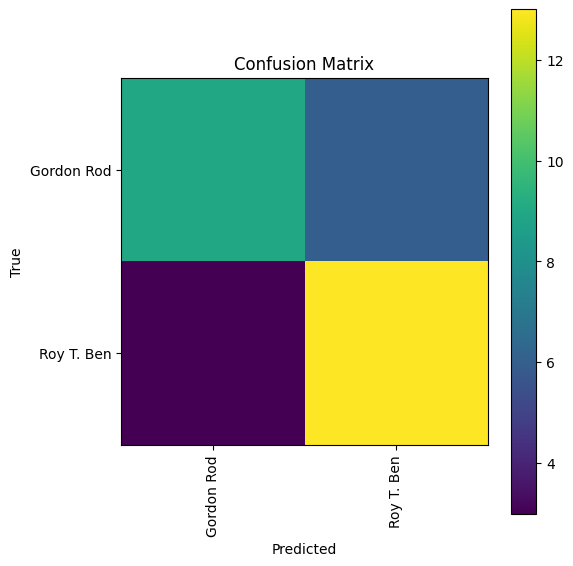

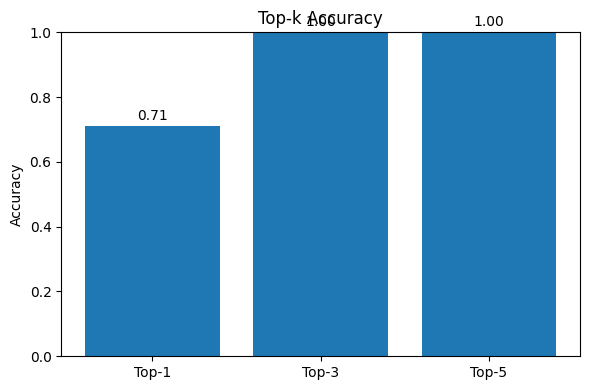

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


[('Roy T. Bennett, The Light in the Heart', 0.5008530616760254), ('Gordon Roddick', 0.4991469085216522)]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# --- Predictions ---
# Probabilities (softmax outputs)
y_pred_proba = model.predict(X_test, verbose=0)

# Top-1
y_pred = np.argmax(y_pred_proba, axis=1)

# Main metrics
acc  = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average="macro")
f1w  = f1_score(y_test, y_pred, average="weighted")
print(f"Test accuracy (Top-1): {acc:.4f} | Macro F1: {f1m:.4f} | Weighted F1: {f1w:.4f}")

#Top-k accuracy
def top_k_accuracy(y_true, y_proba, k=3):
    top_k = np.argsort(y_proba, axis=1)[:, -k:]  # indices of top-k classes for each row
    return np.mean([y_true[i] in top_k[i] for i in range(len(y_true))])

top3_acc = top_k_accuracy(y_test, y_pred_proba, k=3)
top5_acc = top_k_accuracy(y_test, y_pred_proba, k=5)
print(f"Top-3 Accuracy: {top3_acc:.4f} | Top-5 Accuracy: {top5_acc:.4f}")

# Per-class report
labels = np.arange(n_classes)
print("\nPer class report:")
print(classification_report(y_test, y_pred, labels=labels, target_names=le.classes_, zero_division=0))

# Confusion matrix (no seaborn)
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_idx = np.arange(n_classes)
short_labels = [c[:10] for c in le.classes_]
plt.xticks(tick_idx, short_labels, rotation=90)
plt.yticks(tick_idx, short_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#Top-k bar chart
scores = {
    "Top-1": acc,
    "Top-3": top3_acc,
    "Top-5": top5_acc
}

plt.figure(figsize=(6,4))
plt.bar(list(scores.keys()), list(scores.values()))
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy")
for i, (name, val) in enumerate(scores.items()):
    plt.text(i, val + 0.02, f"{val:.2f}", ha="center", fontsize=10)
plt.tight_layout()
plt.show()

#Tiny bot helper
def guess_author(text, top_k=3):
    seq = vectorizer(np.array([text])).numpy()
    probs = model.predict(seq, verbose=0)[0]
    top_idx = probs.argsort()[::-1][:top_k]
    return [(le.classes_[i], float(probs[i])) for i in top_idx]

print(guess_author("It is our choices that show what we truly are, far more than our abilities."))


This just shows the Top-k scores more clearly instead of in the per-class report

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score


def top_k_accuracy(y_true, y_proba, k=3):
    """Calculate top-k accuracy."""
    top_k_preds = np.argsort(y_proba, axis=1)[:, -k:]  # top k indices for each row
    match = [y_true[i] in top_k_preds[i] for i in range(len(y_true))]
    return np.mean(match)

# Standard accuracy (top-1)
acc = accuracy_score(y_test, y_pred)
print(f"Top-1 Accuracy: {acc:.4f}")

# Top-3 and Top-5
top3_acc = top_k_accuracy(y_test, y_pred_proba, k=3)
top5_acc = top_k_accuracy(y_test, y_pred_proba, k=5)

print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")


Top-1 Accuracy: 0.7097
Top-3 Accuracy: 1.0000
Top-5 Accuracy: 1.0000


References:

1. Analytics Vidhya (2019). A Comprehensive Guide to Understand and Implement Text Classification in Python. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/. [Accessed: 26 September 2025]
2. Nissa, N.K. (2022). Text Messages Classification using LSTM, Bi-LSTM, and GRU. [online] Medium. Available at: https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad.[Accessed: 27 September 2025]
3. TensorFlow. (n.d.). Text classification with an RNN. [online] Available at: https://www.tensorflow.org/text/tutorials/text_classification_rnn. [Accessed: 22 September 2025]